In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
AA = np.array([])
BB = np.array([])
CC = np.array([])
DD = np.array([])

for instance_id in range(20):
	file1_num_epoch = f"maQAOA/{instance_id}/num_epoch.csv"
	file2_num_epoch = f"maQAOA_reset_momentum/{instance_id}/num_epoch.csv"
	file3_num_epoch = f"maQAOA_group_param/{instance_id}/num_epoch.csv"
	file4_num_epoch = f"maQAOA_group_param_and_reset_momentum/{instance_id}/num_epoch.csv"	

	A = pd.read_csv(file1_num_epoch, header=None)
	A = np.array(A[0])
	B = pd.read_csv(file2_num_epoch, header=None)
	B = np.array(B[0])
	C = pd.read_csv(file3_num_epoch, header=None)
	C = np.array(C[0])
	D = pd.read_csv(file4_num_epoch, header=None)
	D = np.array(D[0])

	AA = np.concat((AA,A))
	BB = np.concat((BB,B))
	CC = np.concat((CC,C))
	DD = np.concat((DD,D))

	assert len(A)==100
	assert len(B)==100
	assert len(C)==100
	assert len(D)==100
	"""
	print(f"mean number of epoch of original                  of instance {instance_id}: {A.mean()}")
	print(f"mean number of epoch of momentum reset            of instance {instance_id}: {B.mean()}")
	print(f"mean number of epoch of staged                    of instance {instance_id}: {C.mean()}")
	print(f"mean number of epoch of staged and momentum reset of instance {instance_id}: {D.mean()}")
	"""


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm

def truncated_normal_kde(samples, x_grid, bandwidth=0.02, a=0.0, b=1.0):
    """
    Compute KDE using truncated normal kernels.
    samples: 1D data array
    x_grid: evaluation points
    bandwidth: kernel width (std)
    a,b: truncation limits (support)
    """
    n = len(samples)
    pdf = np.zeros_like(x_grid)
    for xi in samples:
        # 標準化後界限
        alpha, beta = (a - xi) / bandwidth, (b - xi) / bandwidth
        pdf += truncnorm.pdf(x_grid, alpha, beta, loc=xi, scale=bandwidth)
    pdf /= n
    return pdf

def auto_bandwidth(data, method='silverman'):
    data = np.asarray(data)
    n = len(data)
    s = np.std(data, ddof=1)
    if method == 'silverman':
        iqr = np.subtract(*np.percentile(data, [75, 25]))
        return 0.9 * min(s, iqr / 1.34) * n ** (-1/5)
    elif method == 'scott':
        return 1.06 * s * n ** (-1/5)
    else:
        raise ValueError("method must be 'silverman' or 'scott'")


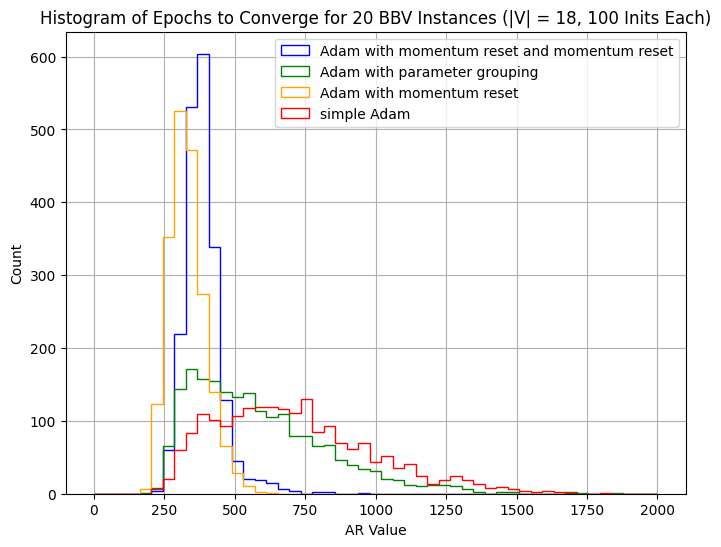

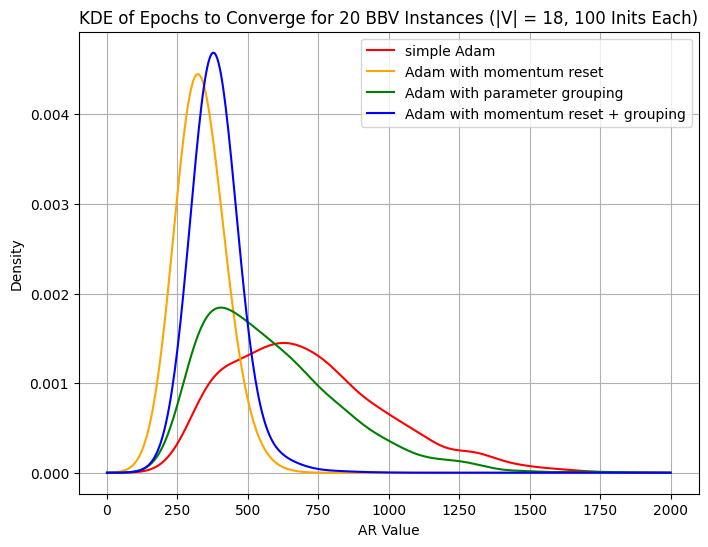

In [4]:
bins = np.linspace(0, 2000, 50)
bin_width = bins[1] - bins[0]
plt.figure(figsize=(8, 6))
plt.hist([AA, BB, CC, DD], bins=bins
		, label=['simple Adam', 'Adam with momentum reset', 'Adam with parameter grouping', 'Adam with momentum reset and momentum reset']
		, color=['red', 'orange', 'green', 'blue']
		,histtype="step")
plt.xlabel('AR Value')
plt.ylabel('Count')
plt.title(f'Histogram of Epochs to Converge for 20 BBV Instances (|V| = 18, 100 Inits Each)')
plt.legend()
plt.grid(True)
plt.show()

# 假設 AA, BB, CC, DD 都是 np.array
x_grid = np.linspace(0, 2000, 400)
bw = auto_bandwidth(AA, 'scott')

plt.figure(figsize=(8,6))
for data, color, label in zip(
    [AA, BB, CC, DD],
    ['red', 'orange', 'green', 'blue'],
    ['simple Adam', 'Adam with momentum reset', 
     'Adam with parameter grouping', 'Adam with momentum reset + grouping']
):
    y = truncated_normal_kde(data, x_grid, bandwidth=bw, a=0, b=1e10)
    plt.plot(x_grid, y, color=color, label=label)

plt.title(f'KDE of Epochs to Converge for 20 BBV Instances (|V| = 18, 100 Inits Each)')
plt.xlabel("AR Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


In [5]:
print(f"mean number of epoch of original                  : {AA.mean()}")
print(f"mean number of epoch of momentum reset            : {BB.mean()}")
print(f"mean number of epoch of staged                    : {CC.mean()}")
print(f"mean number of epoch of staged and momentum reset : {DD.mean()}")

mean number of epoch of original                  : 711.5395
mean number of epoch of momentum reset            : 333.169
mean number of epoch of staged                    : 586.3435
mean number of epoch of staged and momentum reset : 387.35
